In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping  # Import EarlyStopping
from tensorflow.keras.utils import register_keras_serializable
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, LSTM, Dropout, SimpleRNN
import math
import keras.backend as K
import datetime
import tensorflow as tf

# Set seeds for reproducibility
seed_value = 128
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [19]:
df = pd.read_csv(r"C:\Users\aades\Downloads\LSTM_Experiment\LSTM_Experiment\Datasets\Electric_Production.csv", index_col='DATE', parse_dates=True)
df.columns = ["Production"]

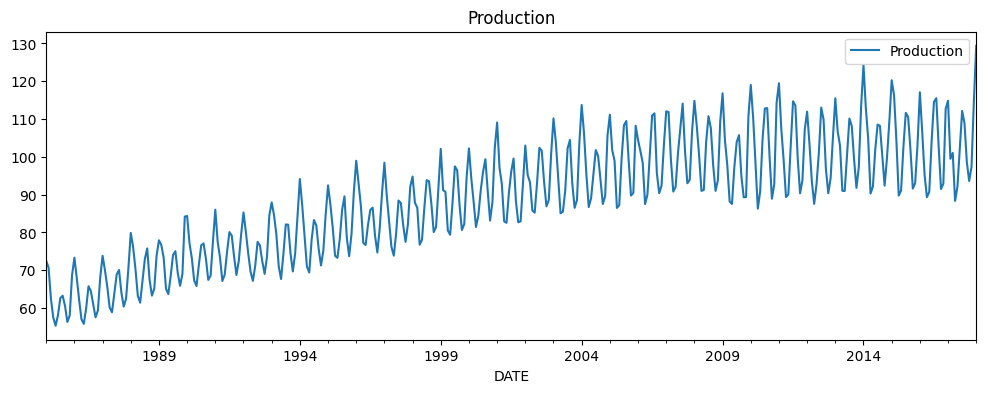

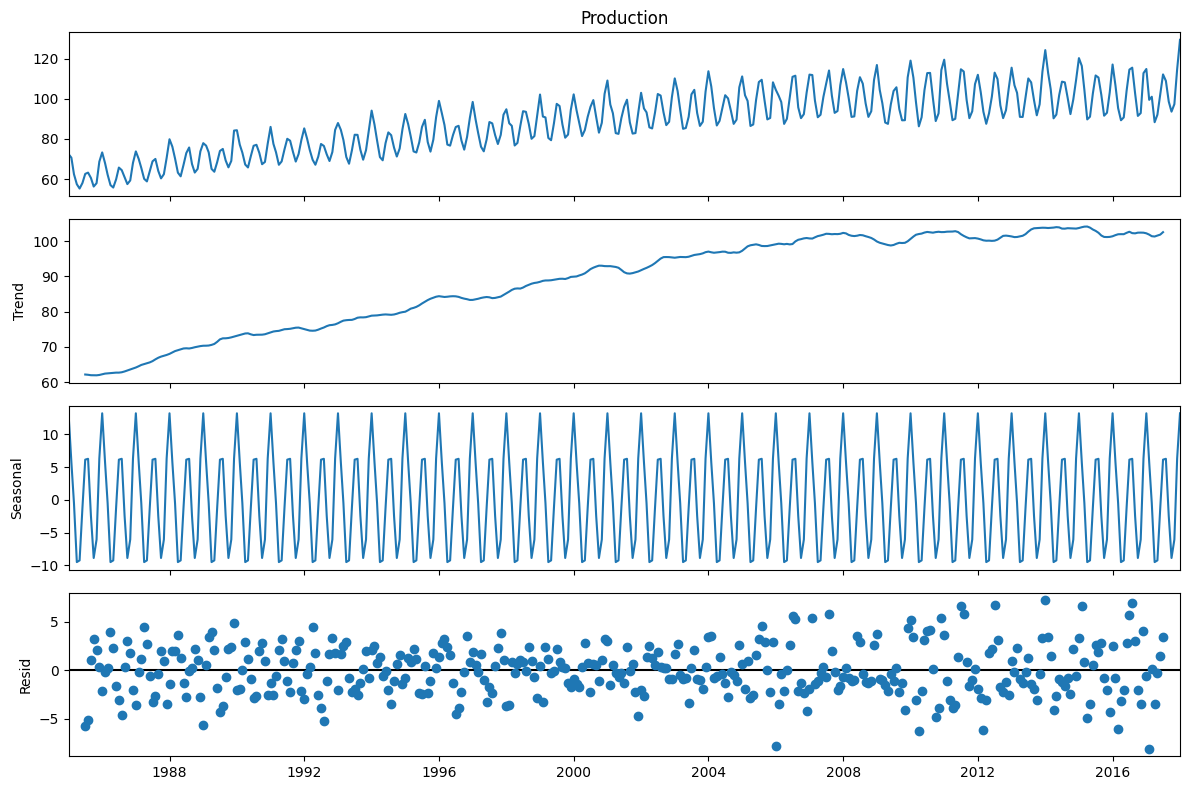

In [20]:
df.isnull().sum()


df.plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('Production')
plt.show(block=False)

rcParams['figure.figsize'] = 12, 8
decomposition = sm.tsa.seasonal_decompose(df.Production)
fig = decomposition.plot()
plt.show()

In [21]:
df1 = df.to_numpy()

In [22]:
def truncate(x, feature_cols=range(1), target_cols=range(1), label_col=1, train_len=7, test_len=20):
    in_, out_= [], []
    for i in range(len(x)-train_len-test_len+1):
        in_.append(x[i:(i+train_len), feature_cols].tolist())
        out_.append(x[(i+train_len):(i+train_len+test_len), target_cols].tolist())
    return np.array(in_), np.array(out_)

X_in, X_out = truncate(df1, feature_cols=range(1), target_cols=range(1), label_col=1, train_len=12, test_len=1)
print(X_in.shape, X_out.shape)

train_x = X_in[:math.floor(X_in.shape[0]*0.70)]
train_y = X_out[:math.floor(X_out.shape[0]*0.70)]
test_x = X_in[math.floor(X_in.shape[0]*0.70):]
test_y = X_out[math.floor(X_out.shape[0]*0.70):]

(385, 12, 1) (385, 1, 1)


In [23]:
def quantile_loss(quantile):
    def loss(y_true, y_pred):
        e = y_true - y_pred
        return tf.reduce_mean(tf.maximum(quantile * e, (quantile - 1) * e), axis=-1)
    return loss

In [24]:
def create_lstm(input_shape, layers, output_dim, dropout_rates):
    initializer = tf.keras.initializers.GlorotNormal(seed=None)
    input_train = Input(shape=input_shape)

    x = input_train
    for i, units in enumerate(layers):
        return_sequences = i < len(layers) - 1 
        x = LSTM(units, activation='relu', kernel_initializer=initializer, return_sequences=return_sequences)(x)

        dropout_rate = dropout_rates[i] if i < len(dropout_rates) else 0.0
        x = Dropout(dropout_rate)(x)
    out = Dense(output_dim)(x)
    
    model = Model(inputs=input_train, outputs=out)
    return model

In [25]:
tf.keras.utils.set_random_seed(48)
tf.config.experimental.enable_op_determinism()
layers = [64]
dropout_rates = [0]
quantile1 = create_lstm((12,1),layers,1,dropout_rates)
quantile2 = create_lstm((12,1),layers,1,dropout_rates)

In [26]:
q1=0.03
q2=0.98
quantile1.compile(loss=quantile_loss(q1),optimizer=Adam(learning_rate=0.01))
quantile2.compile(loss=quantile_loss(q2),optimizer=Adam(learning_rate=0.01))

In [27]:
epc = 300
stop_patience = 10
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=stop_patience, mode='min')

# Training quantile1 with validation data
start_time = datetime.datetime.now()
history = quantile1.fit(train_x, train_y, validation_split=0.1, epochs=epc, 
                            verbose=0, batch_size=64, callbacks=[early_stopping])
end_time = datetime.datetime.now()
total_time1 = round((end_time - start_time).total_seconds(), 2)
print('seconds taken:', total_time1,
      '\nstart_time:', start_time.strftime('%H:%M:%S'),
      'end_time:', end_time.strftime('%H:%M:%S'))

seconds taken: 2.43 
start_time: 17:43:51 end_time: 17:43:53


In [28]:
stop_patience = 5
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=stop_patience, mode='min')
start_time = datetime.datetime.now()
history = quantile2.fit(train_x, train_y, validation_split=0.1, epochs=epc, 
                            verbose=0, batch_size=64, callbacks=[early_stopping])
end_time = datetime.datetime.now()
total_time2 = round((end_time - start_time).total_seconds(), 2)
print('seconds taken:', total_time2,
      '\nstart_time:', start_time.strftime('%H:%M:%S'),
      'end_time:', end_time.strftime('%H:%M:%S'))

seconds taken: 2.24 
start_time: 17:43:53 end_time: 17:43:55


In [29]:
# Predicting and calculating PICP and MPIW
y_l_pred = quantile1.predict(test_x, verbose=0)
y_u_pred = quantile2.predict(test_x, verbose=0)
test_y_ = np.squeeze(test_y[:, 0])
K_u = y_u_pred > test_y_
K_l = y_l_pred < test_y_
PICP = np.mean(K_u * K_l)
MPIW = np.round(np.mean(y_u_pred - y_l_pred), 3)
print('PICP:', PICP)
print('MPIW:', MPIW)

PICP: 0.9392092746730083
MPIW: 67.783


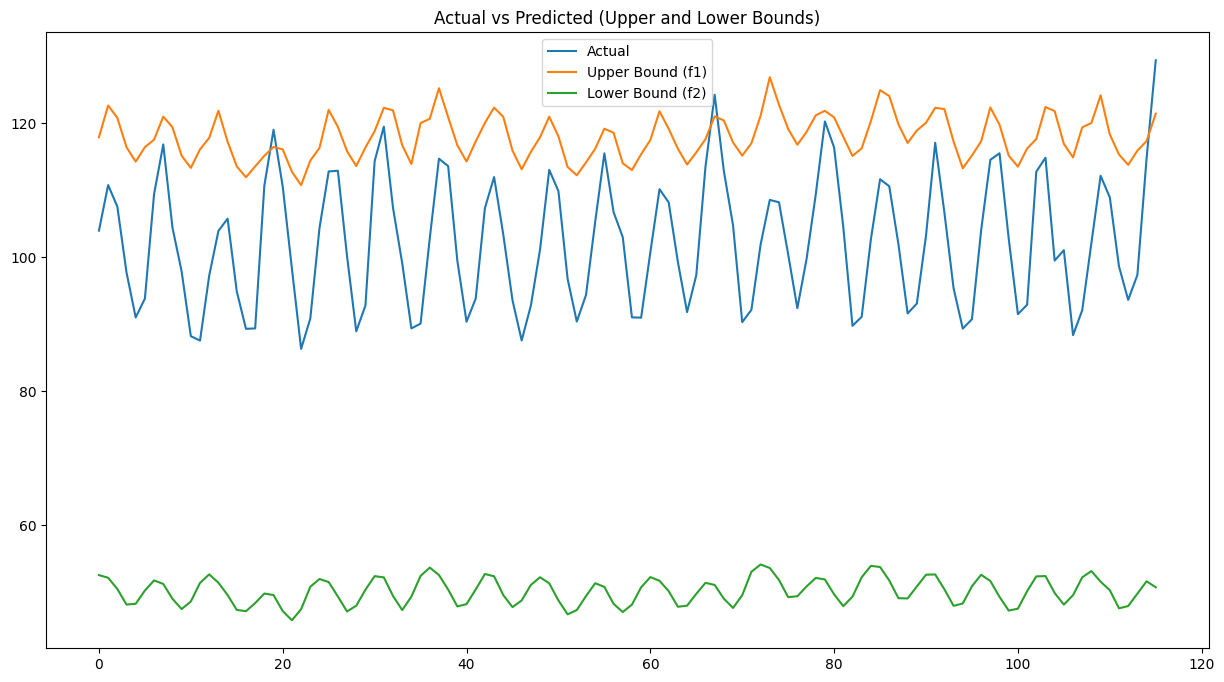

In [30]:
actual = np.squeeze(test_y)
pred1 = y_u_pred
pred2 = y_l_pred
numEx = range(len(actual))
plt.figure(figsize=(15, 8))
plt.plot(numEx, actual, label='Actual')
plt.plot(numEx, pred1, label='Upper Bound (f1)')
plt.plot(numEx, pred2, label='Lower Bound (f2)')
plt.legend(loc='best')
plt.title('Actual vs Predicted (Upper and Lower Bounds)')
plt.show()